## Membuat data sintetik kurva cahaya okultasi dengan fungsi Fresnel

Okultasi merupakan peristiwa tertutupnya obyek langit yang memiliki ukuran sudut lebih kecil oleh obyek langit yang memiliki ukuran sudut lebih besar, misalnya okultasi bintang oleh Bulan. Saat Bulan bergerak menutupi sebuah bintang, maka bayangannya akan bergerak di permukaan Bumi dengan kecepatan $v$.

Jika bayangan ini diamati melalui teleskop, maka intensitas bintang yang terdeteksi akan berfluktuasi dan akhirnya hilang saat bintang sepenuhnya tertutup oleh Bulan. Jika kita meninjau pada suatu panjang gelombang tertentu, $\lambda$,  pola intensitas yang terekam, $F(w)$, bisa dianggap sebagai pola intensitas sebuah obyek titik (*point source*) yang dihalangi oleh sebuah tepian lurus dan tajam, dan bisa dideskripsikan dengan integral Fresnel sebagai berikut:

$$
F(w) = I \times \frac{1}{2} \left[\left(C(w) + \frac{1}{2}\right)^2 + \left(S(w) + \frac{1}{2}\right)^2 \right]
$$

dengan $w$ adalah *Fresnel number*, yang didefinisikan sebagai $w = x\left(\frac{2}{\lambda d}\right)$, dengan $x$ adalah jarak ke tepian bayangan (di permukaan Bumi), dan $d$ adalah jarak Bumi - Bulan saat okultasi terjadi.

Komponen cosinus dan sinus dari integral Fresnel, $C(w)$ dan $S(w)$, dituliskan sebagai:

$$
C(w) = \int_0^w \cos \left( \frac{\pi}{2} t^2 \right) dt \\
S(w) = \int_0^w \sin \left( \frac{\pi}{2} t^2 \right) dt
$$

#### Buat sebuah fungsi untuk integral Fresnel

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(font_scale=1.5)
import scipy.special
import pandas as pd
import pymc3 as pm
import arviz as az

In [2]:
def diffract(t, t0, A, v):
    cc, ss = scipy.special.fresnel(v*(t-t0))
    y = A*0.5*((cc + 0.5)**2 + (ss + 0.5)**2)
    return y

Fungsi di atas merupakan bentuk lain dari fungsi Fresnel yang di dalamnya mengandung komponen trigonometri `cos` dan `sin`. Parameter $t_0$ merupakan waktu terjadinya peristiwa, yaitu saat intensitas bintang turun sekitar 25% dari nilainya, $A$ adalah amplitudo dari kurva cahaya (atau $I$ dalam persamaan sebelumnya), dan $v$ adalah kecepatan bayangan Bulan di permukaan Bumi.

Jika divisualisasikan untuk nilai $v$ yang berbeda, dengan asumsi nilai yang lain sama (misal $A = 100, t_0 = 0$) maka diperoleh gambar berikut:

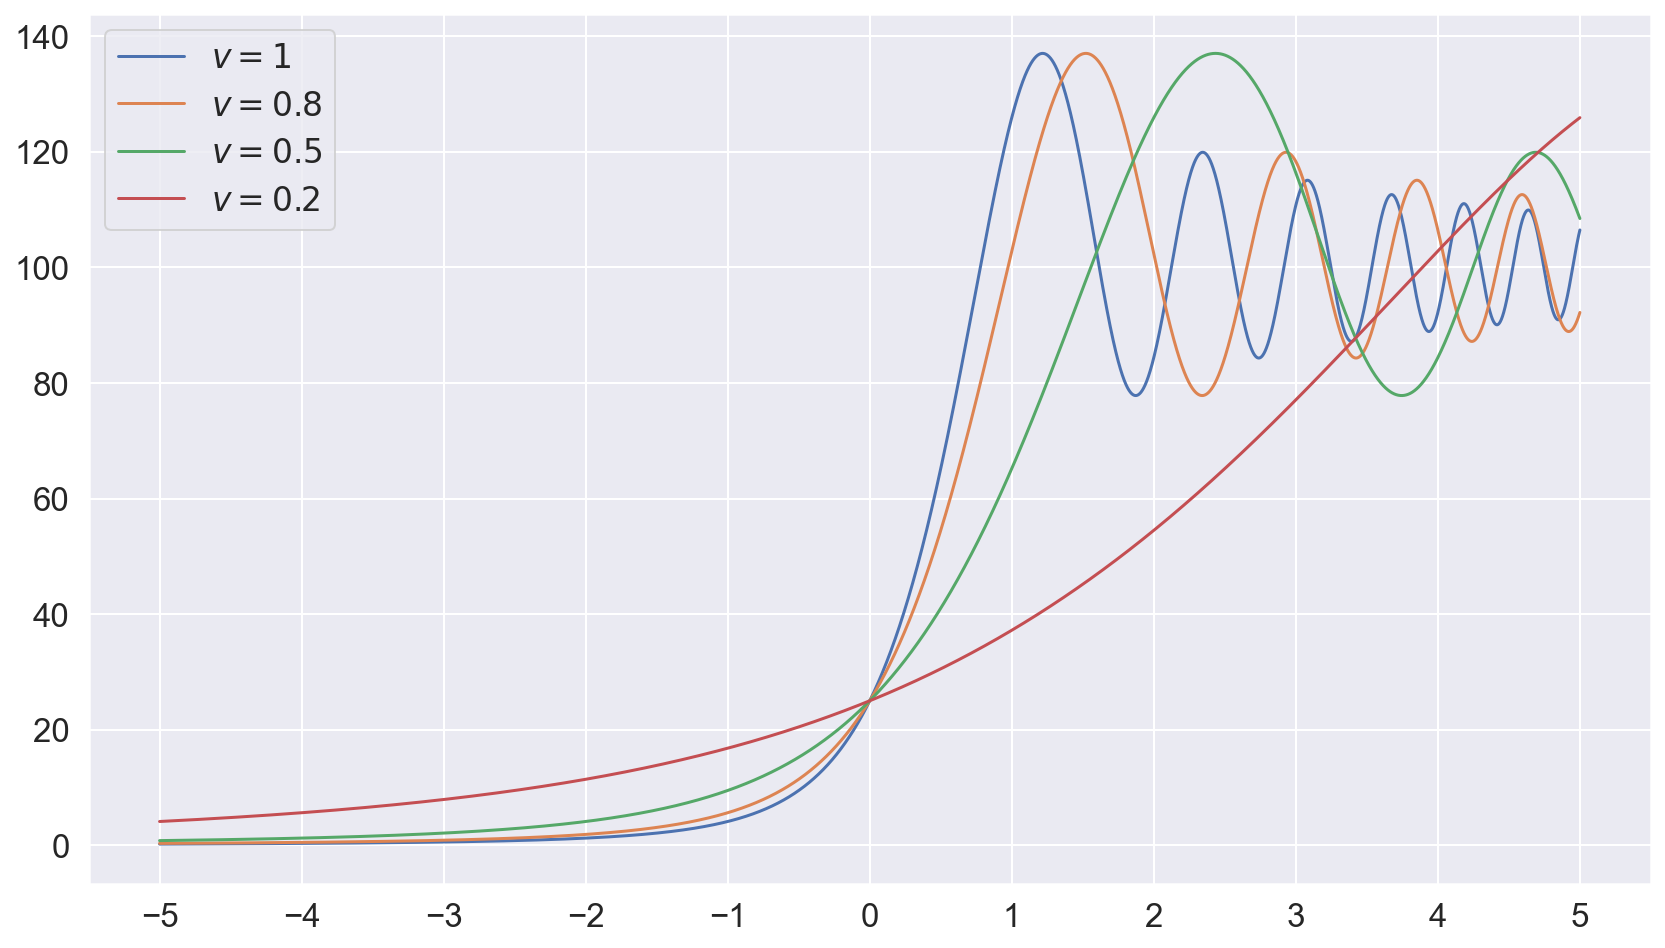

In [38]:
plt.figure(figsize = (14,8), facecolor='w')
nu = np.linspace(-5,5,10000)
plt.plot(nu, diffract(nu, 0, 100, 1))
plt.plot(nu, diffract(nu, 0, 100, 0.8))
plt.plot(nu, diffract(nu, 0, 100, 0.5))
plt.plot(nu, diffract(nu, 0, 100, 0.2))
plt.legend(['$v = 1$','$v = 0.8$', '$v = 0.5$', '$v = 0.2$'])
plt.xticks(np.arange(-5,6));

#### Membuat data artifisial yang mengandung *noise*

Asumsikan parameter yang diambil adalah sebagai berikut:
- nilai *noise* adalah $\sigma = 10$
- amplitudo $A = 100$
- kecepatan $v = 1$
- waktu *event* $t_0 = 0$

In [4]:
x_data = np.linspace(-5, 5, 200)
σ = 10
A = 100
t0 = 0
v = 1

y_data = diffract(x_data, t0, A, v)
y_data = np.random.normal(y_data, scale=σ)

Text(0, 0.5, 'Intensity')

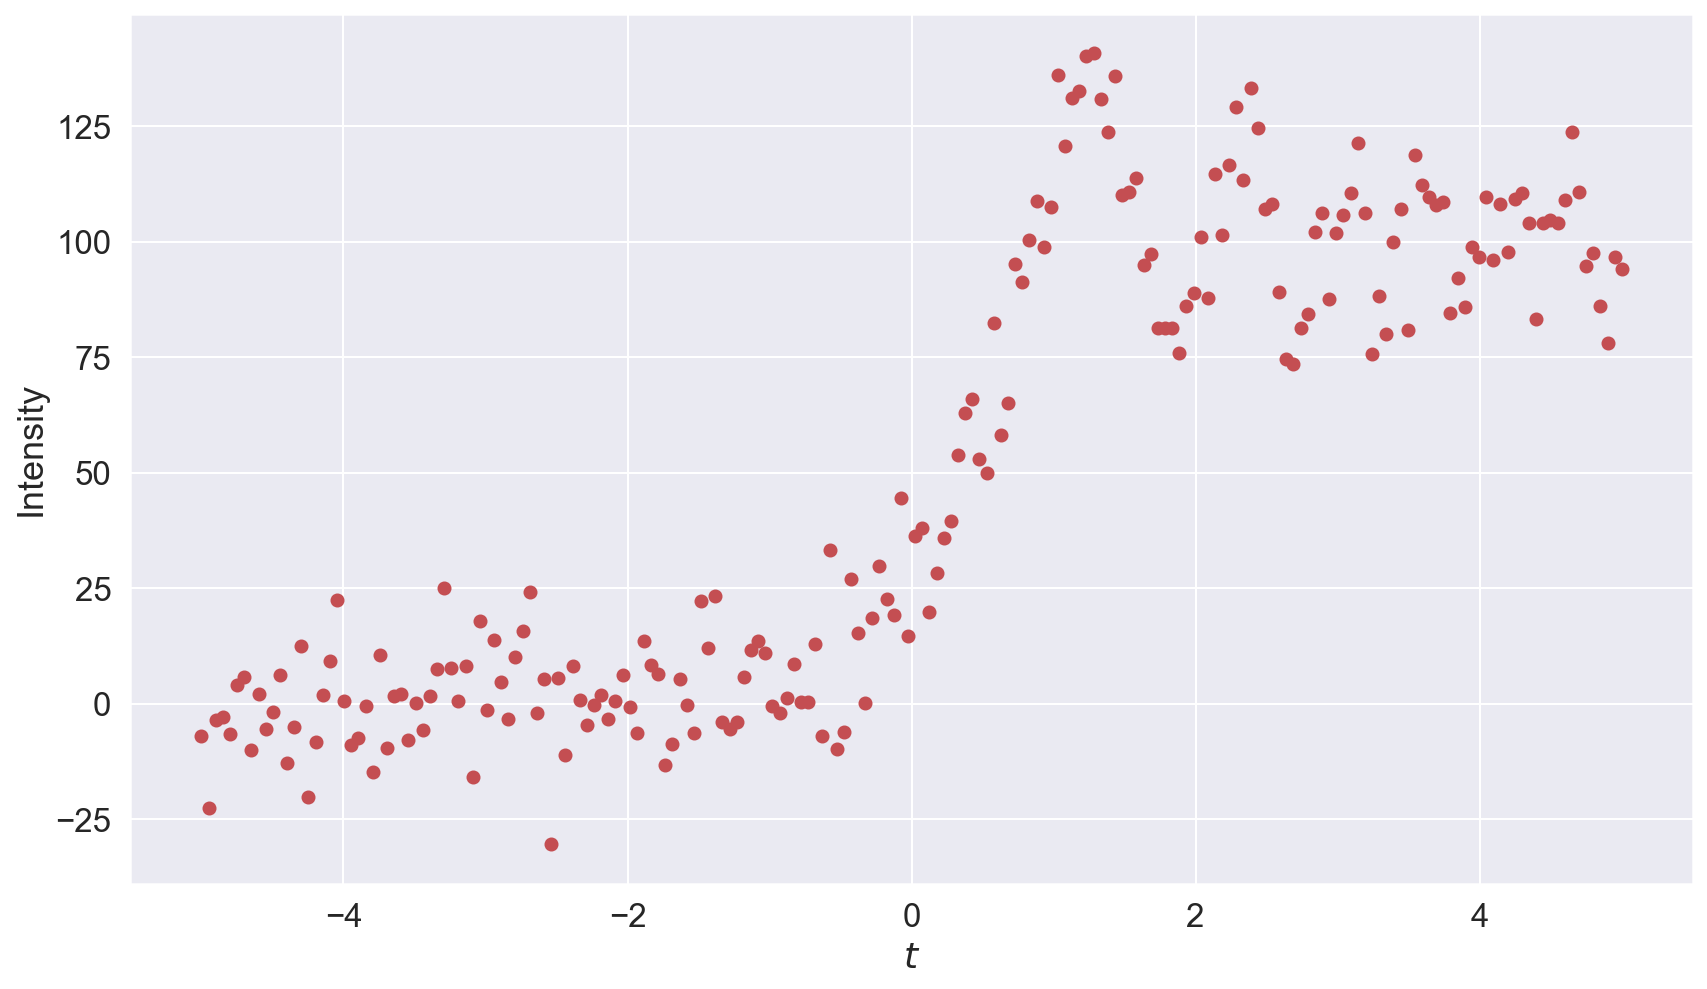

In [5]:
plt.figure(figsize = (14,8), facecolor='w')
plt.scatter(x_data, y_data, c='r')
plt.xlabel(r'$t$')
plt.ylabel('Intensity')

#### *Fitting* dengan metode Bayesian menggunakan MCMC

##### Pembuatan model dan *bayesian inference*

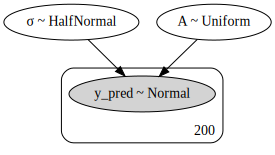

In [6]:
with pm.Model() as model_fresnel:
    amp = pm.Uniform('A', 0, 500)
    σ = pm.HalfNormal('σ', sigma=5)
    mu = diffract(x_data, t0, amp, v) # model-nya (expected value)
    y_pred = pm.Normal('y_pred', mu=mu, sd=σ, observed=y_data) # likelihood-nya

pm.model_to_graphviz(model_fresnel)

In [7]:
with model_fresnel:
    trace = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, A]
Sampling 4 chains, 0 divergences: 100%|██████████████████| 16000/16000 [00:27<00:00, 572.70draws/s]


In [8]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
A,98.979,1.049,96.993,100.920,0.012,0.009,7244.0,7236.0,7258.0,5684.0,1.0
σ,10.236,0.511,9.296,11.196,0.006,0.004,6869.0,6864.0,6855.0,5109.0,1.0


Proses di atas digunakan untuk mendapatkan kembali parameter yang sudah ditentukan sebelumnya. Bandingkan hasil yang diperoleh dengan nilai awalnya ($A = 100, \sigma = 10$).

In [9]:
chain_count =  trace.get_values('A').shape[0]
y_pred_g = pm.sample_posterior_predictive(trace, samples=chain_count, model=model_fresnel)
data_spp = az.from_pymc3(trace=trace, posterior_predictive=y_pred_g)

100%|█████████████████████████████████████████████████████████| 8000/8000 [00:24<00:00, 329.52it/s]


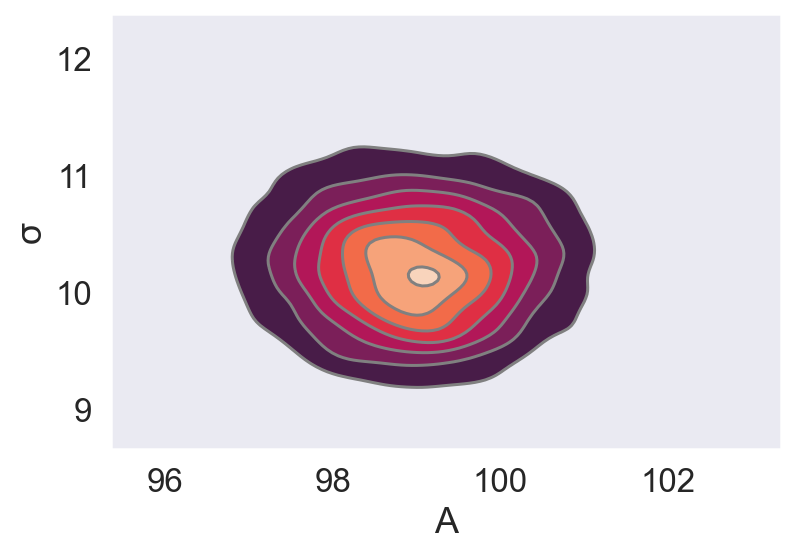

In [10]:
joint_plt = az.plot_pair(data_spp, var_names=['A', 'σ'], kind='kde', fill_last=False);

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002960A3E6B48>,
      dtype=object)

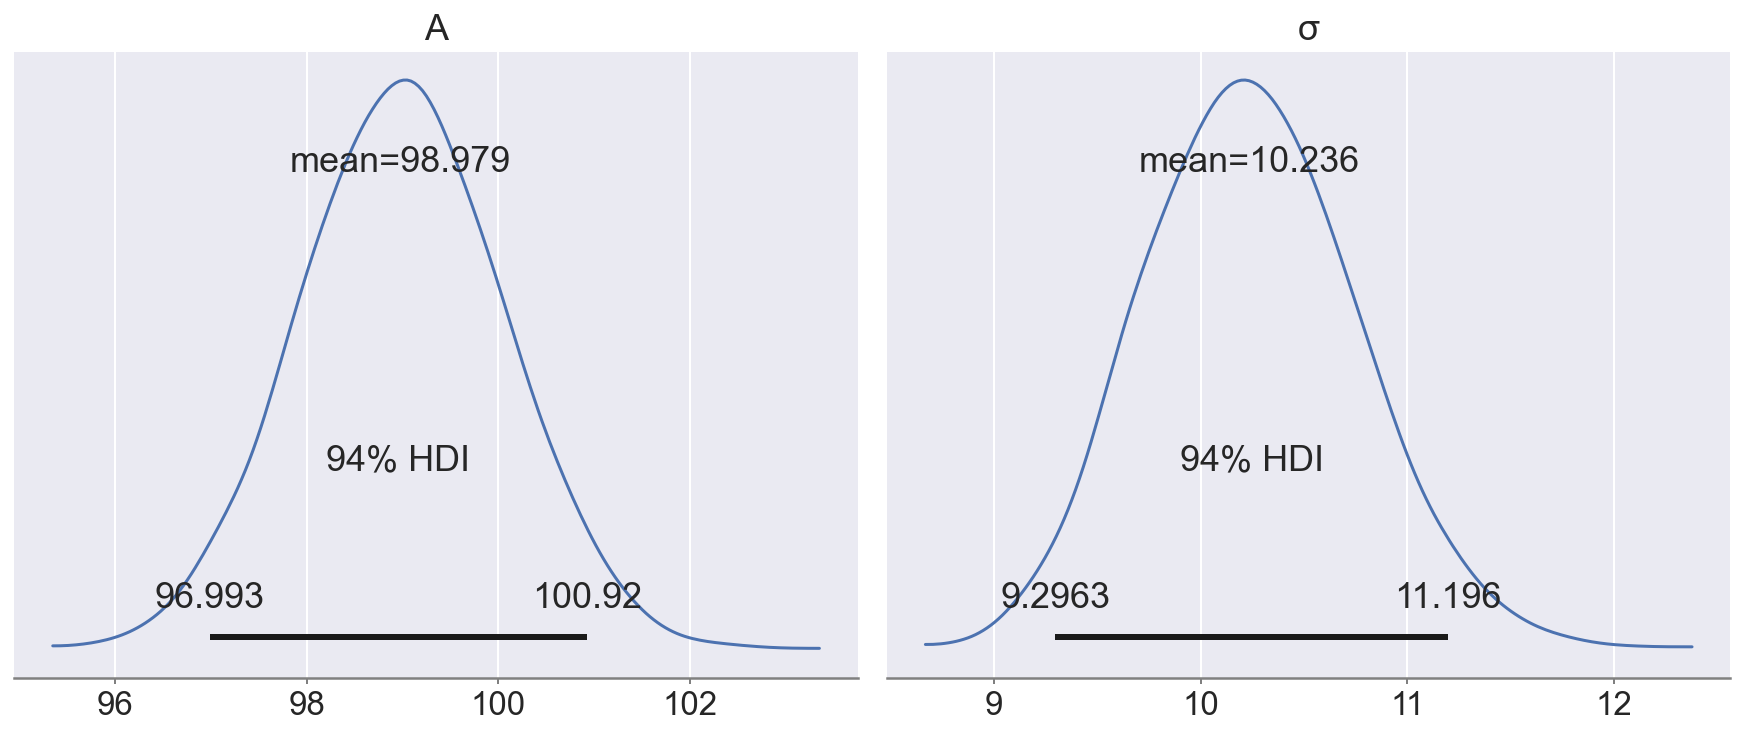

In [11]:
pm.plot_posterior(trace, var_names=None, round_to=5, figsize = (12,5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002960A840308>,
      dtype=object)

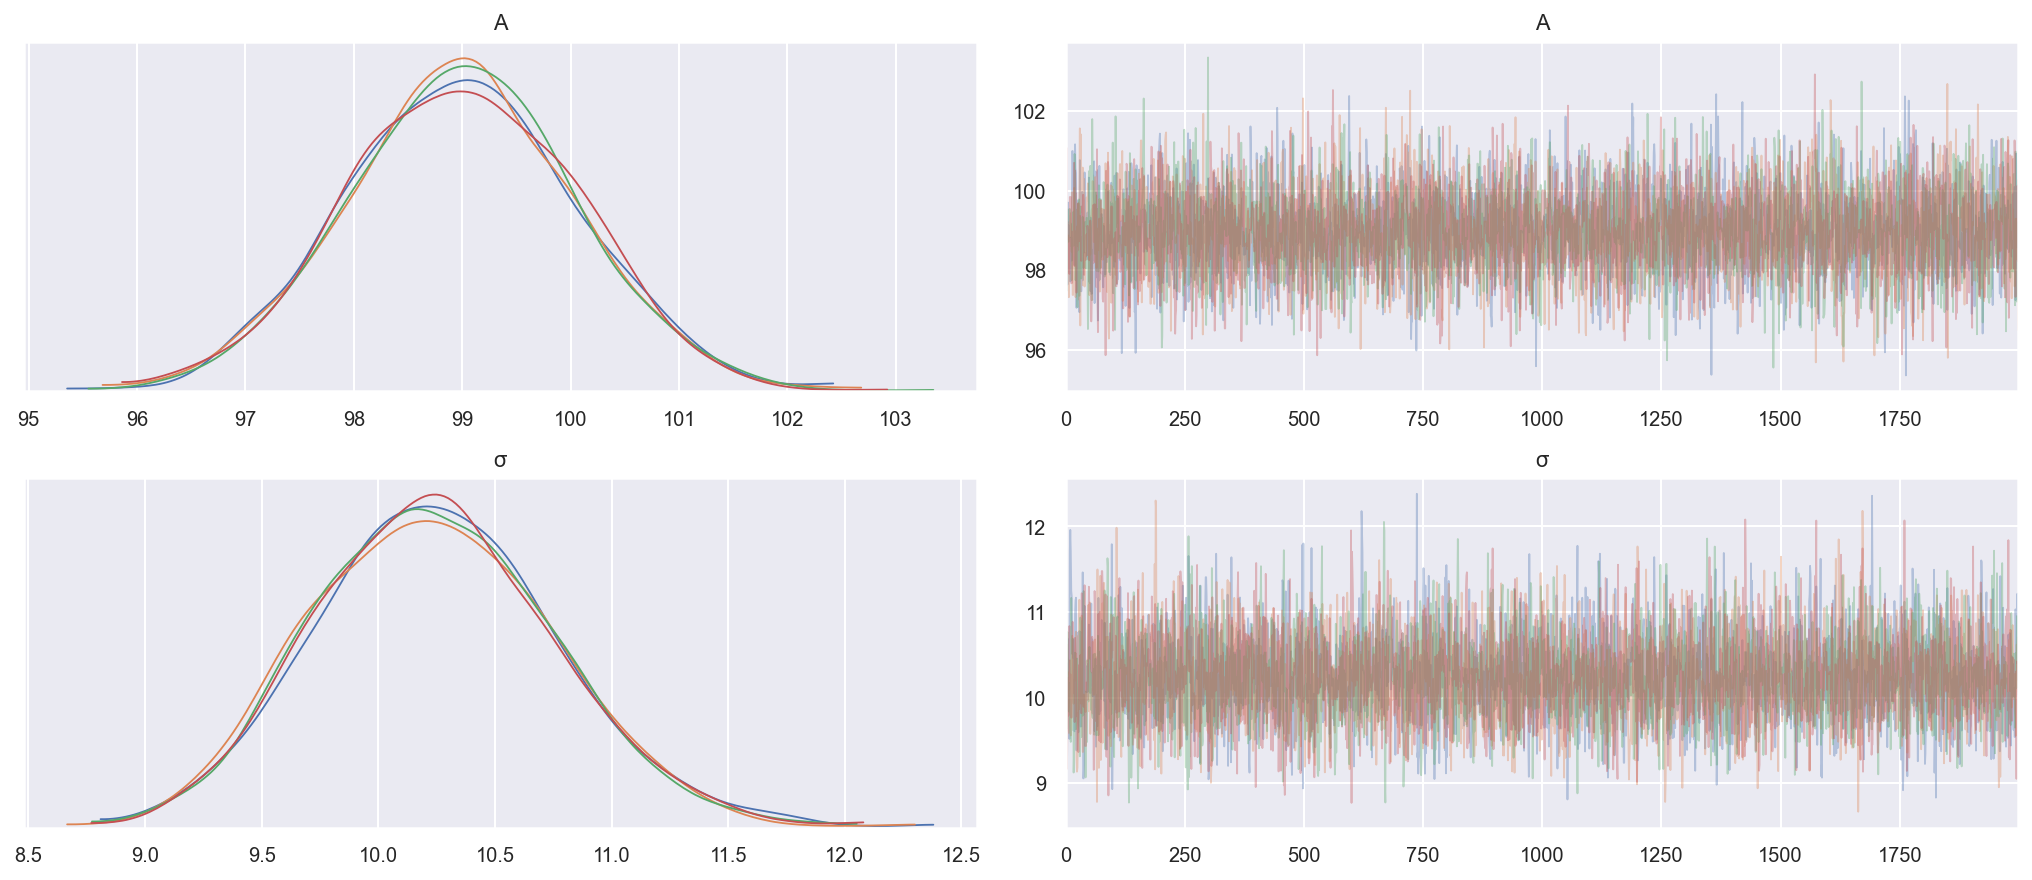

In [12]:
az.plot_trace(trace, figsize=(14,6))

##### Hitung 2,5% dan 97.5% persentil dan plot bersama dengan data

In [13]:
crit_l = np.percentile(y_pred_g['y_pred'], 2.5, axis=0)  # 2.5% persentil 
crit_u = np.percentile(y_pred_g['y_pred'], 97.5, axis=0)  # 97.5% persentil
mean_spp = np.mean(y_pred_g['y_pred'], axis=0) # Median

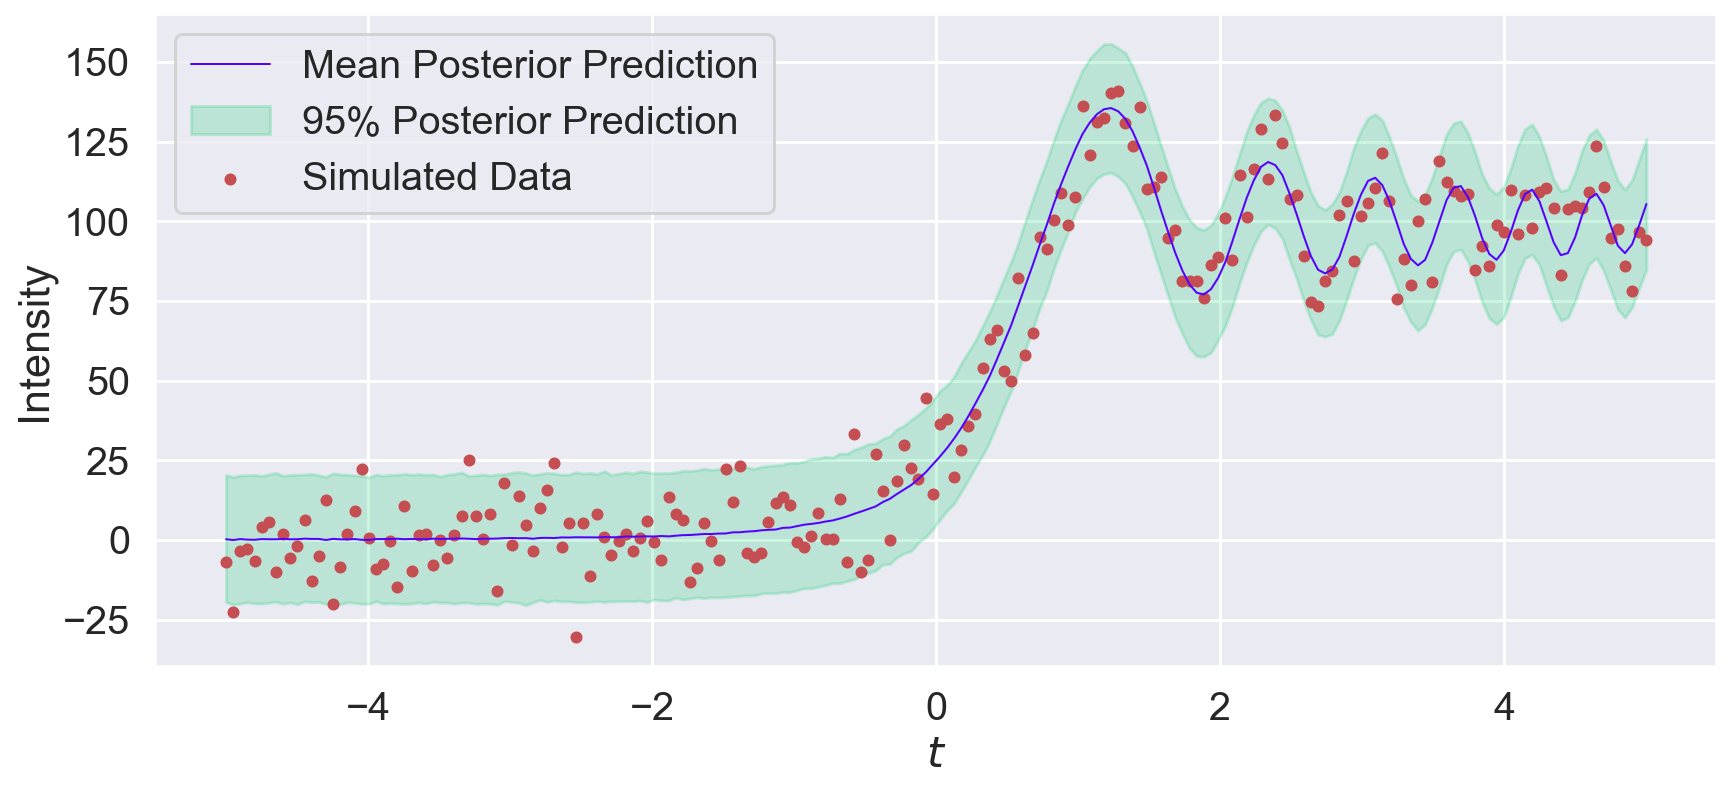

In [14]:
with sns.plotting_context('talk', font_scale=1.2):
    _, ax = plt.subplots(figsize=(14,6 ))

    plt.plot(x_data, mean_spp, linestyle='-', linewidth=1, color="#5500ff")
    plt.fill_between(x_data, crit_l, crit_u, alpha=0.2, color="#00cc66")
    plt.scatter(x_data, y_data, c='r', marker='.')
    plt.xlabel(r'$t$')
    plt.ylabel('Intensity')
    plt.legend(['Mean Posterior Prediction', '95% Posterior Prediction', 'Simulated Data'])

#### *Simulated data* untuk proses *disappearance* 

In [26]:
x_data_2 = np.linspace(-5, 5, 200)
σ = 10
A = 100
t0 = 0
v = 1

y_data_2 = diffract(-x_data_2, t0, A, v)
y_data_2 = np.random.normal(y_data_2, scale=σ)

Text(0, 0.5, 'Intensity')

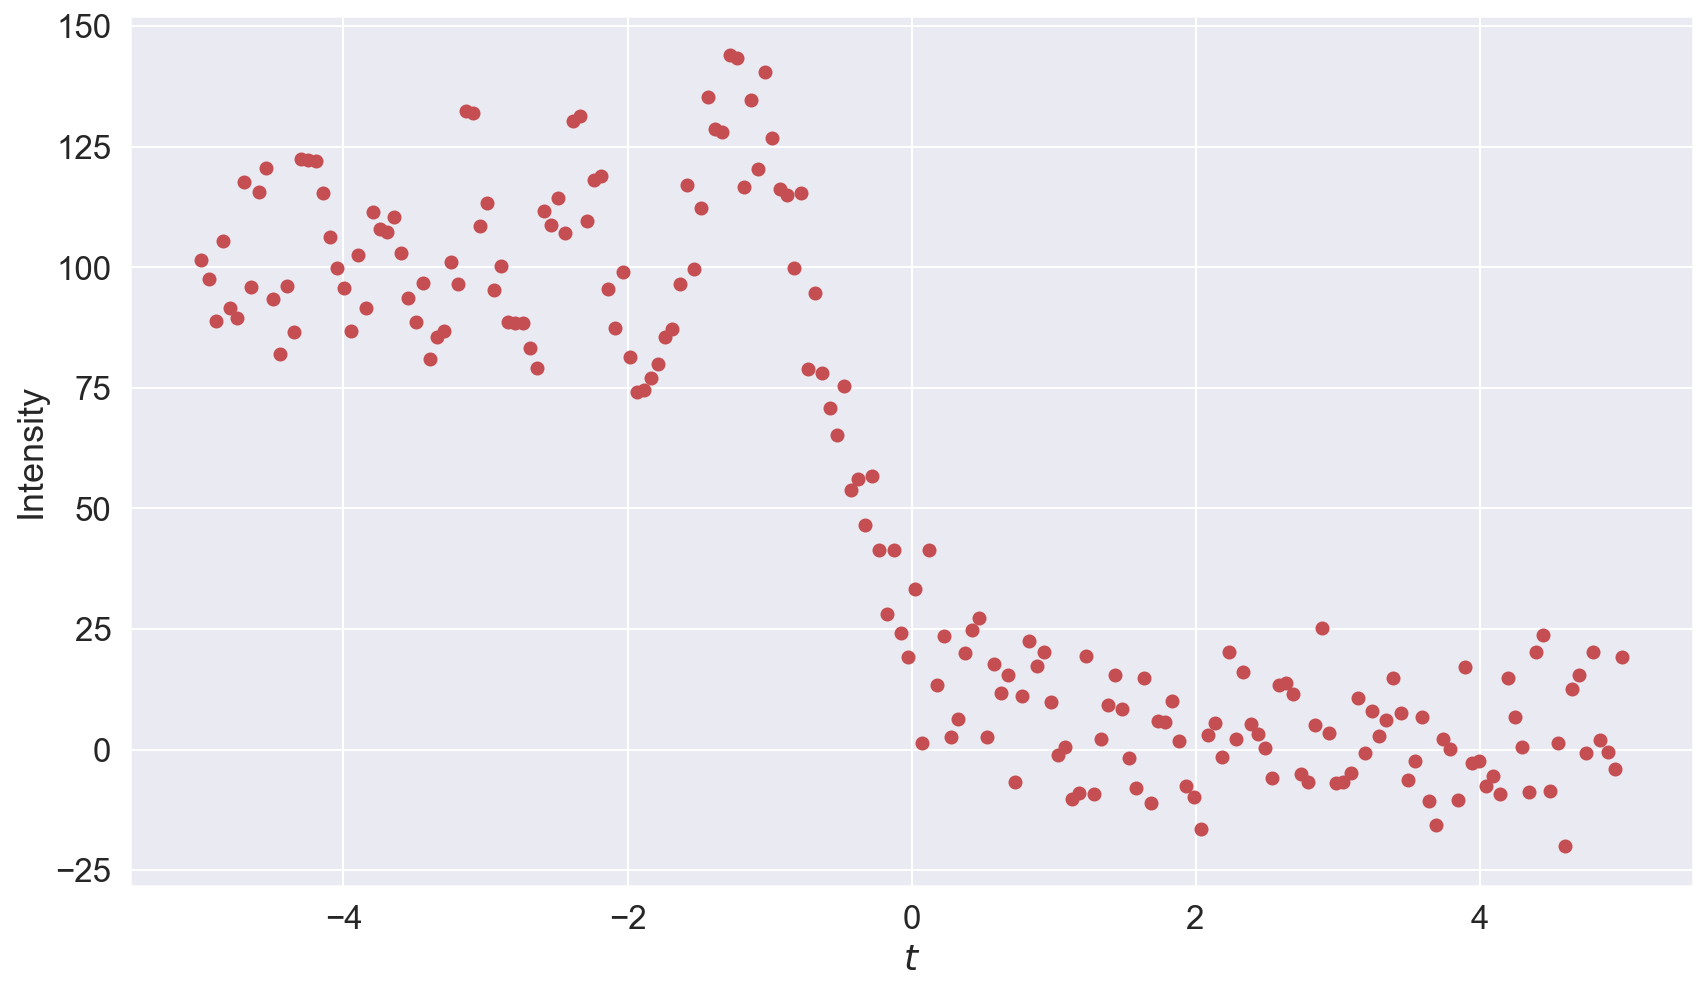

In [27]:
plt.figure(figsize = (14,8), facecolor='w')
plt.scatter(x_data_2, y_data_2, c='r')
plt.xlabel(r'$t$')
plt.ylabel('Intensity')

In [28]:
with pm.Model() as model_fresnel_2:
    amp = pm.Uniform('A', 0, 500)
    σ = pm.HalfNormal('σ', sigma=5)
    mu = diffract(-x_data_2, t0, amp, v) # model-nya (expected value)
    y_pred_2 = pm.Normal('y_pred_2', mu=mu, sd=σ, observed=y_data_2) # likelihood-nya

In [29]:
with model_fresnel_2:
    trace = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, A]
Sampling 4 chains, 0 divergences: 100%|██████████████████| 16000/16000 [00:28<00:00, 563.51draws/s]


In [30]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
A,100.906,0.980,99.061,102.715,0.011,0.008,7307.0,7307.0,7301.0,5493.0,1.0
σ,9.667,0.482,8.773,10.559,0.006,0.004,7334.0,7230.0,7484.0,5644.0,1.0


In [31]:
chain_count_2 =  trace.get_values('A').shape[0]
y_pred_g2 = pm.sample_posterior_predictive(trace, samples=chain_count_2, model=model_fresnel_2)
data_spp2 = az.from_pymc3(trace=trace, posterior_predictive=y_pred_g2)

100%|█████████████████████████████████████████████████████████| 8000/8000 [00:21<00:00, 366.06it/s]


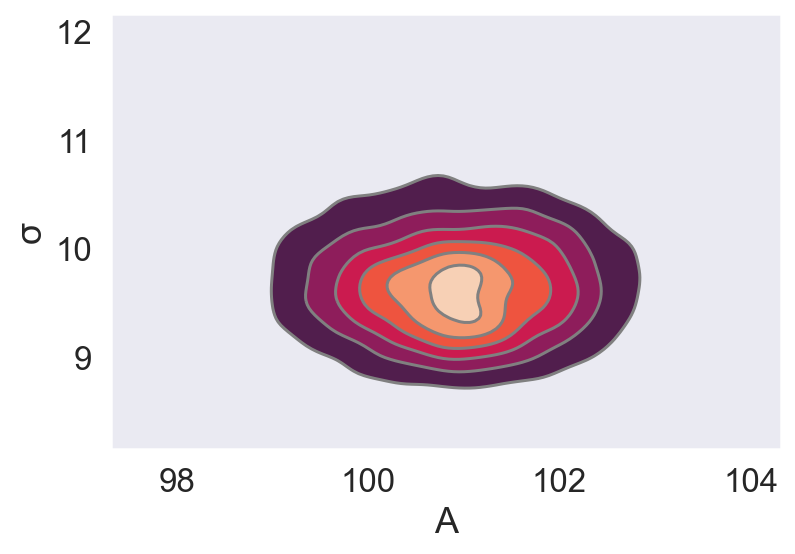

In [32]:
joint_plt2 = az.plot_pair(data_spp2, var_names=['A', 'σ'], kind='kde', fill_last=False);

In [33]:
crit_l2 = np.percentile(y_pred_g2['y_pred_2'], 2.5, axis=0)  # 2.5% persentil 
crit_u2 = np.percentile(y_pred_g2['y_pred_2'], 97.5, axis=0)  # 97.5% persentil
mean_spp2 = np.mean(y_pred_g2['y_pred_2'], axis=0) # Median

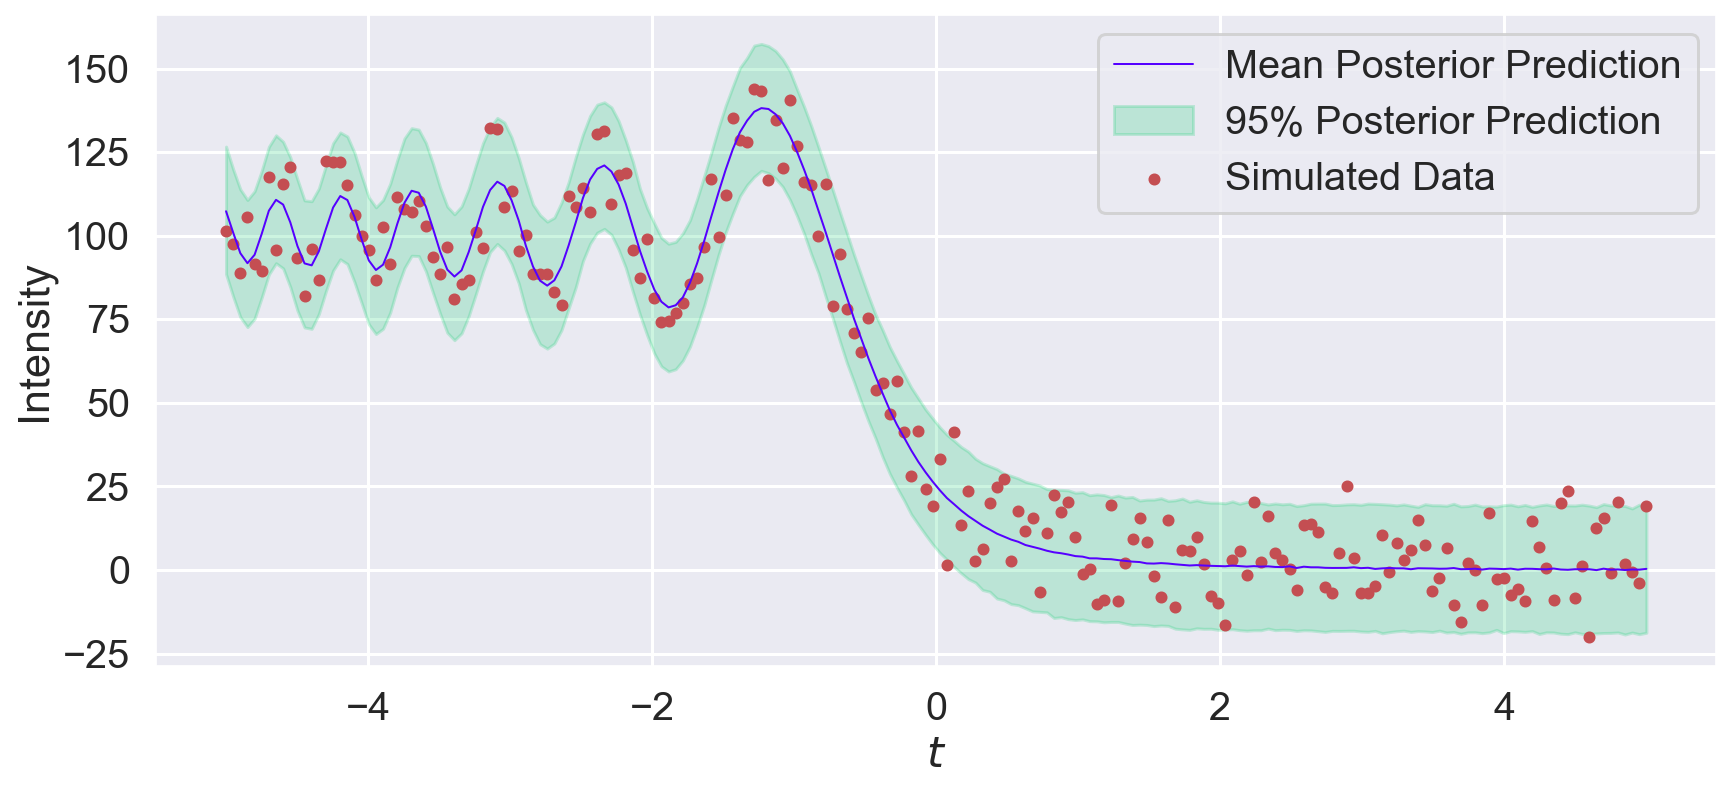

In [34]:
with sns.plotting_context('talk', font_scale=1.2):
    _, ax = plt.subplots(figsize=(14,6 ))

    plt.plot(x_data_2, mean_spp2, linestyle='-', linewidth=1, color="#5500ff")
    plt.fill_between(x_data_2, crit_l2, crit_u2, alpha=0.2, color="#00cc66")
    plt.scatter(x_data_2, y_data_2, c='r', marker='.')
    plt.xlabel(r'$t$')
    plt.ylabel('Intensity')
    plt.legend(['Mean Posterior Prediction', '95% Posterior Prediction', 'Simulated Data'])